# Fine Tune GPT-2 Model

Open Questions:
- Is it useful to add \<bot> statement as preparing step? -> yesss
- Should one batch, one dialog?
- Currently the dialogs are mixed, so only question and answer is paired right now
    - How to fix?
    - The batches?
- Removing Bot answers?<br>
    From:<br>
    '<start> Create me a unique interactive story to calm with the topic: Ocean. <bot>:Ah, the ocean... <end>',<br>
    "<start> Ah, the ocean. Such a ... <end>",<br>
    "<start> Yes, I can feel it...'<br>
    <br>
    to:<br>
    '<start> Create me a unique interactive story to calm with the topic: Ocean. <bot>:Ah, the ocean... <end>',<br>
    "<start> Yes, I can feel it...'<br>


1. **Dialog-based Approach:**
   - **One Batch, One Dialog:**
     - Treat each dialog as a separate training example. This allows the model to learn the context and flow of individual conversations.
     - Helps the model focus on capturing the nuances of each conversation independently.
     - Useful if your storytelling involves short, distinct dialogs.

   - **Inclusion of the Past:**
     - You can include the past history within each dialog example. Concatenate the previous turns in the conversation to provide context.
     - This helps the model understand the context and continuity of the ongoing dialog.
     - Be mindful of the token limit, as GPT-2 has a maximum token limit, and longer sequences might get truncated.

2. **Memory and Context:**
   - GPT-2 has a limited context window due to its fixed input size. If the conversations are long, you might lose relevant information.
   - Consider balancing the length of your input sequences to ensure the model can capture essential details.

3. **Dynamic Context Window:**
   - Instead of a fixed history length, you could use a sliding window approach.
   - Maintain a dynamic context window that moves along the conversation, incorporating the most recent interactions.

4. **Experiment and Evaluate:**
   - It's often beneficial to experiment with different approaches to see what works best for your specific use case.
   - Conduct thorough evaluations using validation data to ensure the model is learning effectively and providing desired responses.

5. **Training Strategies:**
   - Experiment with hyperparameters like learning rate, batch size, and the number of training epochs to fine-tune the model effectively.
   - Monitor the model's performance on both training and validation sets.

Preprocess: handling tokenization, special tokens, and managing the context window.

Hint: Use the dialogs.txt file to train the model on google colab.

### Imports

In [1]:
!python --version

Python 3.10.12


In [2]:
#!python -m pip install torch
#!python -m pip install transformers

In [3]:
#from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import json

import transformers
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

In [4]:
os.listdir("./")

['.config', 'dialogs.txt', 'sample_data']

### Load and Prepare the data

In [5]:
MODEL_PATH = "./model/model.pth"
MODEL_WEIGHT_PATH = "./model/model_weights.pth"
ONNX_PATH = "./model/model.onnx"
MAX_LENGTH = 1024
# ".pt", ".pth", ".pkl", or ".h5"

class Dialog_Data(Dataset):

    def __init__(self, tokenizer, data_dir_path="./data", read_one_file=False):
        self.tokenizer = tokenizer
        self.data_dir_path = data_dir_path
        self.read_data(data_dir_path, read_one_file)

    def read_data(self, data_dir_path, read_one_file, should_save_as_one_file=True):
        data = []
        conversations = []
        if read_one_file:
            with open("./dialogs.txt", "r", encoding="latin1") as f:
                raw = f.read()
            for dialog in raw.split("#/"):
                cur_conversation = []
                for sentence in dialog.split(";"):
                    data += [sentence]
                    cur_conversation += [sentence]
                conversations += [(cur_conversation)]
        else:
            for dialog in os.listdir(self.data_dir_path):
                    with open(f"{self.data_dir_path}/{dialog}", "r") as f:
                        cur_conversation = []
                        for idx, line in enumerate(f.read().split("\n")):
                            content = ":".join(line.split(":")[1:]).strip()
                            if len(content) > 0:
                                if idx == 0:
                                    data += [f"Create me a unique interactive story to calm with the topic: {content}"]
                                    cur_conversation += [f"Create me a unique interactive story to calm with the topic: {content}"]
                                else:
                                    data += [content]
                                    cur_conversation += [content]
                    conversations += [(cur_conversation)]
            if should_save_as_one_file:
                save_data = ""
                for idx_1, dialog in enumerate(conversations):
                    if idx_1 > 0:
                        save_data += "#/"

                    for idx_2, elem in enumerate(dialog):
                        if idx_2 == 0:
                            save_data += f"{elem}"
                        else:
                            save_data += f";{elem}"
                    with open("./dialogs.txt", "w") as f:
                        f.write(save_data)

        # add markers:
        for idx in range(0, len(data)-1):    # last elem should be skipped
                data[idx] = f"<start> {data[idx]} <bot>:{data[idx+1]} <end>"

        self.conversations = conversations
        self.data = data[:-1]    # [:3000]
        self.encoded_data = self.tokenizer(self.data, truncation=True, return_tensors="pt", max_length=MAX_LENGTH, padding="max_length", padding_side="right") # max_length=40, padding="max_length"

        self.input_ids = self.encoded_data['input_ids']
        self.attention_mask = self.encoded_data['attention_mask']

        # set max len of the input and mask -> for padding the data
        # MAX_INPUT_LEN = 0
        # for cur_i in self.input_ids:
        #     if len(cur_i) > MAX_INPUT_LEN:
        #         MAX_INPUT_LEN = len(cur_i)
        # self.MAX_INPUT_LEN = MAX_INPUT_LEN

        # MAX_ATTENTION_LEN = 0
        # for cur_i in self.attention_mask:
        #     if len(cur_i) > MAX_ATTENTION_LEN:
        #         MAX_ATTENTION_LEN = len(cur_i)
        # self.MAX_ATTENTION_LEN = MAX_ATTENTION_LEN

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # transform to tensor
        # input_ = torch.Tensor(self.input_ids[idx])
        # attention_mask_ = torch.Tensor(self.attention_mask[idx])

        # add padding, that every batch have the same size
        # padding_input = self.MAX_INPUT_LEN - len(input_)
        # padding_attention_mask = self.MAX_ATTENTION_LEN - len(attention_mask_)
        # if padding_input > 0:
        #     input_ = torch.cat((input_, torch.zeros(padding_input)))
        # if padding_attention_mask > 0:
        #     attention_mask_ = torch.cat((attention_mask_, torch.zeros(padding_attention_mask)))
        return (self.input_ids[idx], self.attention_mask[idx])



In [6]:
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({  "pad_token": "<pad>",
                                "bos_token": "<start>",
                                "eos_token": "<end>"})
tokenizer.add_tokens(["<bot>:"])

1

In [7]:
data = Dialog_Data(tokenizer=tokenizer, read_one_file=True)
data = DataLoader(data, batch_size=64)
#  make the batch-size bigger, 64, 128

In [8]:
# check the data
[print(i, "\n") for i in data.dataset.data[:3]];

<start> Create me a unique interactive story to calm with the topic: Ocean. <bot>:Ah, the ocean. Such a vast, serene place. Close your eyes for a moment and take a deep breath, imagining the salty scent of the sea. Now, picture yourself standing on a beautiful sandy beach, the warmth of the golden sun touching your skin. Can you feel it? <end> 

<start> Yes, I can feel it. It's so inviting and peaceful. <bot>:As you stand there, listen closely. Can you hear the gentle rhythm of the waves washing ashore? It's as if the ocean is whispering a calming melody just for you. Take a moment to tune in and let these soothing sounds wash away any stress or worries you may have. <end> 

<start> I am focusing on the sounds of the waves, feeling them melting away my tension. It's like a lullaby for the soul. <bot>:Now, let your imagination guide you towards the water's edge. As you approach, notice how the sand feels beneath your feet - soft and welcoming, with each grain embracing your toes. With e

In [9]:
len(data.dataset.data)

29997

In [10]:
# # Test saved dialogs in one file
# counter = 0
# with open("./dialogs.txt", "r") as f:
#     dialogs = f.read()
# print(f"Dialogs amount: {len(os.listdir('./data'))}")
# print(f"In one file dialogs amount: {len(dialogs.split('#'))}")

In [11]:
counter = 0
for i, a in data:
    counter += 1
    if counter <= 1:
        print(i)
        print(type(i))
        print(a)
        print(type(a))

counter

tensor([[50258, 13610,   502,  ..., 50257, 50257, 50257],
        [50258,  3363,    11,  ..., 50257, 50257, 50257],
        [50258,   314,   716,  ..., 50257, 50257, 50257],
        ...,
        [50258,  1081,   345,  ..., 50257, 50257, 50257],
        [50258,  2295,  1671,  ..., 50257, 50257, 50257],
        [50258,  1081,   262,  ..., 50257, 50257, 50257]])
<class 'torch.Tensor'>
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
<class 'torch.Tensor'>


469

### Load pretrained model

In [12]:
config = transformers.GPT2Config.from_pretrained("gpt2")
config.do_sample = config.task_specific_params['text-generation']['do_sample']
config.max_length = config.task_specific_params['text-generation']['max_length']
model = transformers.GPT2LMHeadModel.from_pretrained("gpt2", config=config)
model.resize_token_embeddings(len(tokenizer))
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

In [14]:
model = model.to(device)

### First test

In [15]:
# prompt = "Create me an interactive story to calm me down."
# encoded = tokenizer.encode(prompt, return_tensors="pt")
# print(f"Encoding: {encoded}\n")
# res = tokenizer.decode(model.generate(encoded)[0])
# print(f"Prompt:\n{prompt}\n\nResult:\n{res}");

In [16]:
def inference(prompt:str, model, tokenizer, device, padding, clear_output=True):
    model.eval()

    prompt = f"<startofstring> {prompt} <bot>:"
    prompt = tokenizer(prompt, return_tensors="pt", padding=padding)
    X = prompt["input_ids"].to(device)
    a = prompt["attention_mask"].to(device)
    output = model.generate(X, attention_mask=a, pad_token_id=tokenizer.eos_token_id)
    output = tokenizer.decode(output[0])

    # clean output:
    if clear_output:
        if "<bot>:" in output:
            output = output.split("<bot>:")[1:]

        if "<endofstring>" in output:
            output = output.replace("<endofstring>", "")

    if type(output) == list and len(output) == 1:
        output = output[0]
    return output

In [17]:
inference(prompt="Create me a unique interactive story to calm with the topic: Ocean.", model=model, tokenizer=tokenizer,
                                                        device=device, padding="max_length", clear_output=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 1024, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


['<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [18]:
inference(prompt="Hey.", model=model, tokenizer=tokenizer, device=device, padding="max_length", clear_output=False)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 1024, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


'<startofstring> Hey. <bot>:<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

### Fine Tune Model

Epoch 1/12, Training Loss: 1.5003, Steps: 469
Epoch 2/12, Training Loss: 1.3575, Steps: 938
Epoch 3/12, Training Loss: 1.2683, Steps: 1407
Epoch 4/12, Training Loss: 1.2065, Steps: 1876
Epoch 5/12, Training Loss: 1.1694, Steps: 2345
Epoch 6/12, Training Loss: 1.1247, Steps: 2814
Epoch 7/12, Training Loss: 1.0943, Steps: 3283
Epoch 8/12, Training Loss: 1.0414, Steps: 3752
Epoch 9/12, Training Loss: 1.0182, Steps: 4221
Epoch 10/12, Training Loss: 0.9885, Steps: 4690
Epoch 11/12, Training Loss: 0.9570, Steps: 5159
Epoch 12/12, Training Loss: 0.9309, Steps: 5628


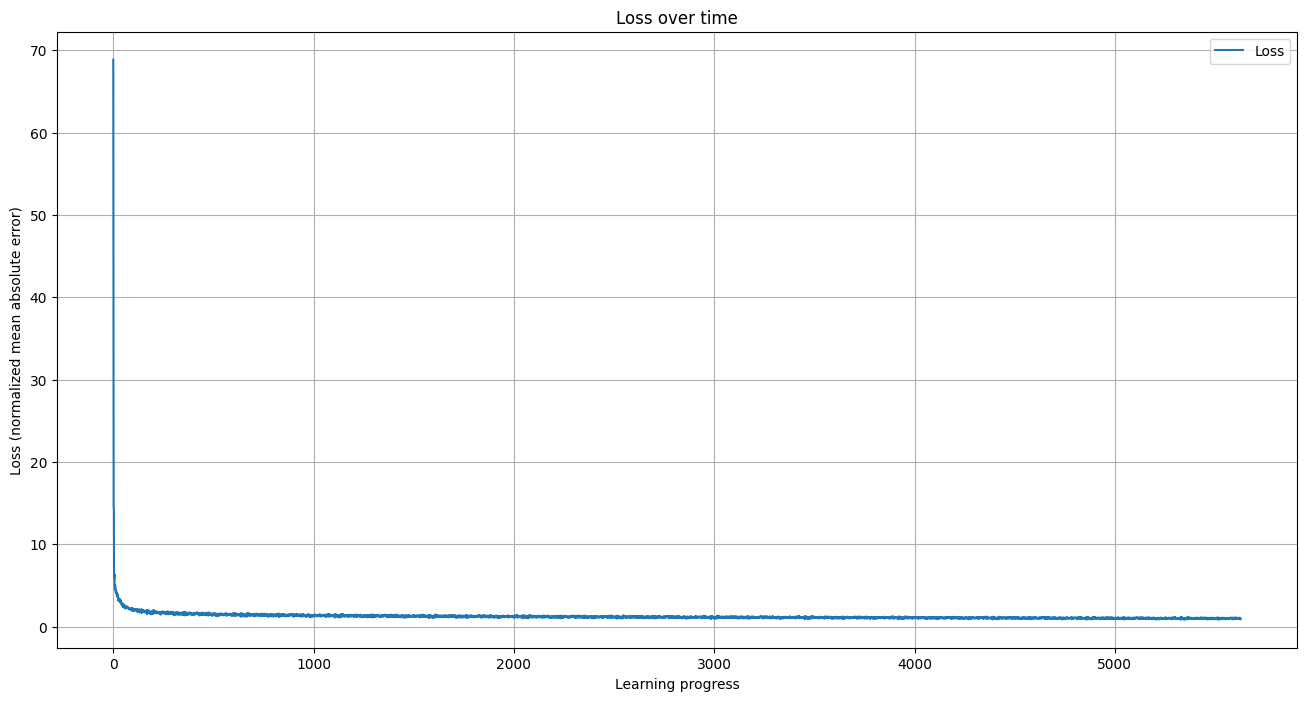

In [19]:
optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 12

loss_hist = []
steps = 0

solutions = []
solutions_cleared = []

for cur_epoch in range(0, epochs):
    model.train()
    for input_ids, attention_mask in data:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        # shift labels?
        optimizer.zero_grad()
        loss = model(input_ids, attention_mask=attention_mask, labels=input_ids).loss
        loss_hist += [loss.item()]
        loss.backward()
        optimizer.step()
        steps += 1
    torch.save(model.state_dict(), "./model_state.pt")
    print(f'Epoch {cur_epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Steps: {steps}')
    solutions += [inference(prompt="Create me a unique interactive story to calm with the topic: Ocean.", model=model, tokenizer=tokenizer,
                                                        device=device, padding=True, clear_output=False)]
    solutions_cleared += [inference(prompt="Create me a unique interactive story to calm with the topic: Ocean.", model=model, tokenizer=tokenizer,
                                                        device=device, padding=True, clear_output=True)]

# plot loss
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(np.arange(len(loss_hist)), loss_hist, label='Loss')
ax.set_xlabel('Learning progress')
ax.set_ylabel('Loss (normalized mean absolute error)')
ax.set_title('Loss over time')
ax.legend()
ax.grid()

# save step solution-predictions:
with open("./result_per_epoch.txt", "w") as f:
    res = ""
    for i, cur_res in enumerate(solutions, start=1):
        res += f"\n{'-'*16}\n{i:02d}. Epoch:\n{cur_res}"
    f.write(res)

### Save model

-> Propably save the model in a extra repository/branch and provide it as python module<br>
-> Is model very big?

save only weights

In [21]:
torch.save(model.state_dict(), MODEL_WEIGHT_PATH)

# loading
# config = transformers.GPT2Config.from_pretrained("gpt2")
# config.do_sample = config.task_specific_params['text-generation']['do_sample']
# config.max_length = config.task_specific_params['text-generation']['max_length']
# model = transformers.GPT2LMHeadModel.from_pretrained("gpt2", config=config)
# model.resize_token_embeddings(len(tokenizer))

# model.load_state_dict(torch.load(MODEL_WEIGHT_PATH))
# model.eval()

save whole model

In [22]:
torch.save(model, MODEL_PATH)

# loading
# model = torch.load(MODEL_PATH)
# model.eval()

save as ONNX

see here -> https://onnxruntime.ai/docs/get-started/with-python.html<br>
or here -> https://pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html

In [29]:
def get_example_data():
    for i, a in data:
        return i, a
i, a = get_example_data()

i = i.to(device)

# or:

# text = "Text from the news article"
# text = torch.tensor(text_pipeline(text))
# offsets = torch.tensor([0])

In [31]:
#!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 26.7 MB/s eta 0:00:00


In [33]:
torch.onnx.export(model,                     # model being run
                  i,                    # model input (or a tuple for multiple inputs)
                  ONNX_PATH,                 # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output']  # the model's output names
                    )

# loading
# import onnx

# onnx_model = onnx.load(ONNX_PATH)
# onnx.checker.check_model(onnx_model)

# import onnxruntime as ort
# import numpy as np
# ort_sess = ort.InferenceSession('ag_news_model.onnx')
# outputs = ort_sess.run(None, {'input': text.numpy(),
#                             'offsets':  torch.tensor([0]).numpy()})
# # Print Result
# result = outputs[0].argmax(axis=1)+1
# print("This is a %s news" %ag_news_label[result[0]])

OutOfMemoryError: ignored

### Use the model

-> Test the model

In [23]:
start_sentence = "Create me a unique interactive story to calm with the topic:"

In [24]:
loop = 0
while True:
    user_input = input()
    if user_input.lower() in ["q", "quit", "e", "exit", "", "x"]:
        print("See you later! I hope you had fun ^^")
        break
    elif user_input in ["restart", "new"]:
        loop = 0
    if loop == 0:
        user_input = f"{start_sentence} {user_input}"
    print("Bot:", inference(user_input, model=model, device=device, tokenizer=tokenizer, padding="max_length", clear_output=False))
    loop += 1

NameError: name 'inference' is not defined

In [ ]:
# def infer(inp):
#   inp = " " + inp + " : "
#   inp = tokenizer(inp, return_tensors="pt")
#   X = inp["input_ids"].to(device)  # Use .to(device) method to move the tensor to the specified device
#   a = inp["attention_mask"].to(device)  # Use .to(device) method here as well

#   output = model.generate(X, attention_mask=a, max_length=100, num_return_sequences=1)

#   output = tokenizer.decode(output[0])

#   return output

---
### Ressources:

- https://www.toolify.ai/ai-news/finetuning-gpt2-for-conversational-chatbots-10476
- https://huggingface.co/docs/transformers/model_doc/gpt2
- [PyTorch kompakt](https://www.thalia.de/shop/home/artikeldetails/A1062166688)
- https://pytorch.org/tutorials/beginner/chatbot_tutorial.html
- https://github.com/itsuncheng/fine-tuning-GPT2/tree/master

<br>

---